## Mounting Drive

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan
import matplotlib.pyplot as plt
import umap

## Loading the Dataset

In [4]:
def process_trade_file(filepath):
    df = pd.read_csv(filepath)

    # Remove timezone info from 'Time'
    df['Time'] = df['Time'].str.replace(r'\s\+\d+.*$', '', regex=True)

    # Parse datetime with explicit format
    df['timestamp'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

    df['buy_volume'] = np.where(df['IsMarketMaker'] == False, df['Quantity'], 0)
    df['sell_volume'] = np.where(df['IsMarketMaker'] == True, df['Quantity'], 0)

    # Round to nearest second (use 's' not 'S')
    df['timestamp'] = df['timestamp'].dt.floor('s')

    # Drop rows with NaT
    df.dropna(subset=['timestamp'], inplace=True)

    # Aggregate per second
    agg = df.groupby('timestamp').agg({
        'buy_volume': 'sum',
        'sell_volume': 'sum'
    }).reset_index()

    return agg

def load_all_trade_data(trade_dir):
    trade_files = [os.path.join(trade_dir, f) for f in os.listdir(trade_dir) if f.endswith('.txt')]
    trade_dfs = [process_trade_file(f) for f in trade_files]
    return pd.concat(trade_dfs, ignore_index=True)

def process_depth_file(filepath):
    df = pd.read_csv(filepath)
    df.rename(columns={'Time': 'timestamp'}, inplace=True)

    # Remove timezone info
    df['timestamp'] = df['timestamp'].str.replace(r'\s\+\d+.*$', '', regex=True)

    # Parse datetime (timezone-naive to match trade data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')

    df.dropna(subset=['timestamp'], inplace=True)

    return df


def load_all_depth_data(depth_dir):
    depth_files = [os.path.join(depth_dir, f) for f in os.listdir(depth_dir) if f.endswith('.txt')]
    depth_dfs = [process_depth_file(f) for f in depth_files]
    return pd.concat(depth_dfs, ignore_index=True)

## Feature Engineering

In [5]:
def feature_engineering(depth_df):
    # Rename bid/ask price and qty for level 1
    depth_df['bid_1_price'] = depth_df['BidPriceL1']
    depth_df['ask_1_price'] = depth_df['AskPriceL1']
    depth_df['bid_qty_1'] = depth_df['BidQtyL1']
    depth_df['ask_qty_1'] = depth_df['AskQtyL1']

    # Mid Price
    depth_df['mid_price'] = (depth_df['bid_1_price'] + depth_df['ask_1_price']) / 2

    # Spread
    depth_df['spread'] = depth_df['ask_1_price'] - depth_df['bid_1_price']

    # Imbalance
    depth_df['imbalance_lvl1'] = (
        (depth_df['bid_qty_1'] - depth_df['ask_qty_1']) /
        (depth_df['bid_qty_1'] + depth_df['ask_qty_1'] + 1e-9)
    )

    # Microprice
    depth_df['microprice'] = (
        (depth_df['bid_1_price'] * depth_df['ask_qty_1'] +
         depth_df['ask_1_price'] * depth_df['bid_qty_1']) /
        (depth_df['bid_qty_1'] + depth_df['ask_qty_1'] + 1e-9)
    )

    # Cumulative Depth
    bid_qty_cols = [f'BidQtyL{i}' for i in range(1, 21)]
    ask_qty_cols = [f'AskQtyL{i}' for i in range(1, 21)]
    depth_df['cum_bid_qty'] = depth_df[bid_qty_cols].sum(axis=1)
    depth_df['cum_ask_qty'] = depth_df[ask_qty_cols].sum(axis=1)

    # Returns & Volatility
    depth_df['returns'] = np.log(depth_df['mid_price'] / depth_df['mid_price'].shift(1))
    depth_df['volatility_10s'] = depth_df['returns'].rolling(window=10, min_periods=1).std()
    depth_df['volatility_30s'] = depth_df['returns'].rolling(window=30, min_periods=1).std()

    return depth_df

## Merge Depth and Trade Data

In [6]:
def merge_data(depth_df, trade_df):
    # Drop any remaining null timestamps
    depth_df = depth_df.dropna(subset=['timestamp'])
    trade_df = trade_df.dropna(subset=['timestamp'])

    depth_df = depth_df.sort_values('timestamp')
    trade_df = trade_df.sort_values('timestamp')

    merged = pd.merge_asof(
        depth_df,
        trade_df,
        on='timestamp',
        direction='nearest',
        tolerance=pd.Timedelta(seconds=1)
    )

    merged['buy_volume'] = merged['buy_volume'].fillna(0)
    merged['sell_volume'] = merged['sell_volume'].fillna(0)
    merged['volume_imbalance'] = merged['buy_volume'] - merged['sell_volume']
    return merged

## Feature Normalization & Clustering

In [7]:
def normalize_and_cluster(df):
    features = df.select_dtypes(include=np.number).dropna(axis=1)

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)

    pca = PCA(n_components=0.9)
    pca_data = pca.fit_transform(scaled_data)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
    df['regime'] = clusterer.fit_predict(pca_data)

    return df, pca_data

## Visualization

In [8]:
def visualize_regimes(df, pca_data):
    plt.figure(figsize=(15, 5))
    plt.scatter(df['timestamp'], df['mid_price'], c=df['regime'], cmap='viridis', s=1)
    plt.title('Market Regimes Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Mid Price')
    plt.tight_layout()
    plt.show()

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(pca_data)
    plt.figure(figsize=(10, 6))
    plt.scatter(embedding[:, 0], embedding[:, 1], c=df['regime'], cmap='viridis', s=2)
    plt.title('UMAP Projection of Regimes')
    plt.tight_layout()
    plt.show()

## Main Function

Loading trade data...
Loading depth data...
Engineering features...
Merging depth and trade...
Clustering market regimes...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Visualizing regimes...


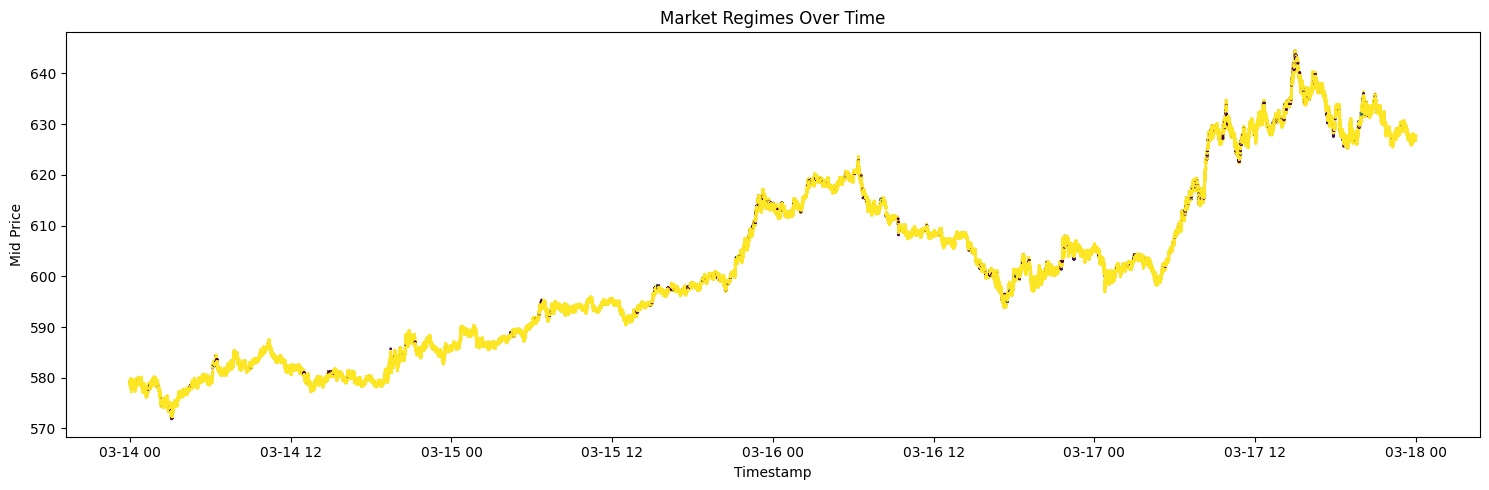

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


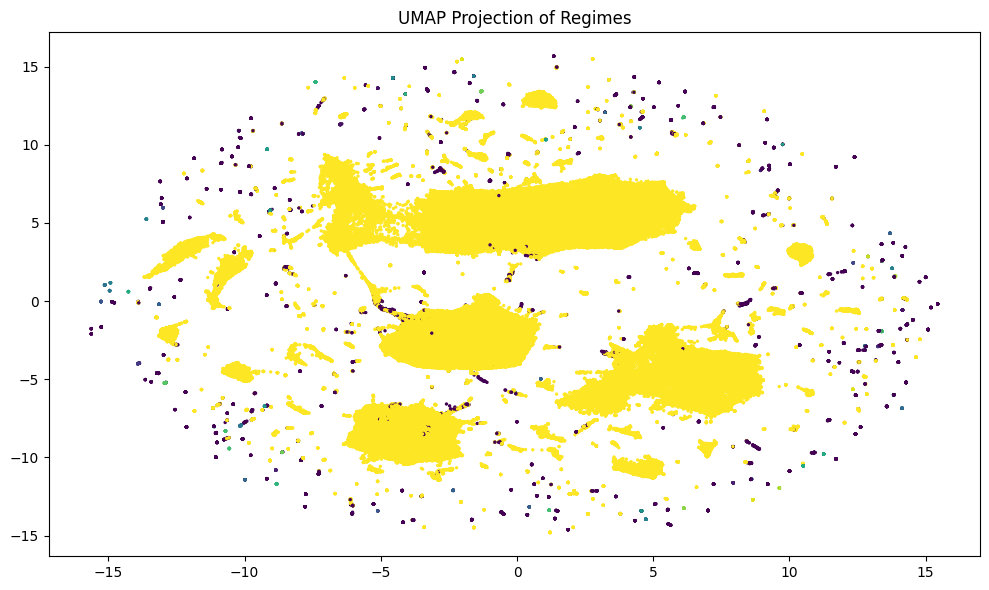

Done ✅


In [13]:
def main():
    depth_dir = "/content/drive/MyDrive/Regime_Detection/Data/depth20_1000ms"
    trade_dir = "/content/drive/MyDrive/Regime_Detection/Data/aggTrade"

    print("Loading trade data...")
    trade_df = load_all_trade_data(trade_dir)

    print("Loading depth data...")
    depth_df = load_all_depth_data(depth_dir)

    print("Engineering features...")
    depth_df = feature_engineering(depth_df)

    print("Merging depth and trade...")
    merged_df = merge_data(depth_df, trade_df)

    print("Clustering market regimes...")
    clustered_df, pca_data = normalize_and_cluster(merged_df)

    print("Visualizing regimes...")
    visualize_regimes(clustered_df, pca_data)

    print("Done ✅")

if __name__ == "__main__":
    main()